# Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.inputs.keras import PlotLossesCallback
import numpy as np
import PIL
from PIL import ImageOps, ImageFilter
from skimage import io
#increase default chart size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

# loading the Data

In [2]:
DATA_PATH = '/Users/esraan/Desktop/PHD/machine_learning/assignments/ML_3/jpg/'
PATH = "/Users/esraan/Desktop/PHD/machine_learning/assignments/ML_3/"

In [3]:
# Setting seed for reproducibility

RANDOM_SEED = 51
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [4]:
# read all file names directly from the archive and targets for them
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted([f for f in os.listdir(DATA_PATH) if not os.path.isfile(f)])
#files = [f for f in os.listdir(DATA_PATH) if os.path.isfile(f)]
df['Category'] = scipy.io.loadmat(PATH+'imagelabels.mat')['labels'][0] 
df['Category'] = df['Category'].astype(str)

df.head()

,Id,Category
0,image_00001.jpg,77
1,image_00002.jpg,77
2,image_00003.jpg,77
3,image_00004.jpg,77
4,image_00005.jpg,77


# Visualizing Random sample of images for different classes

Sample pictures (random sample)


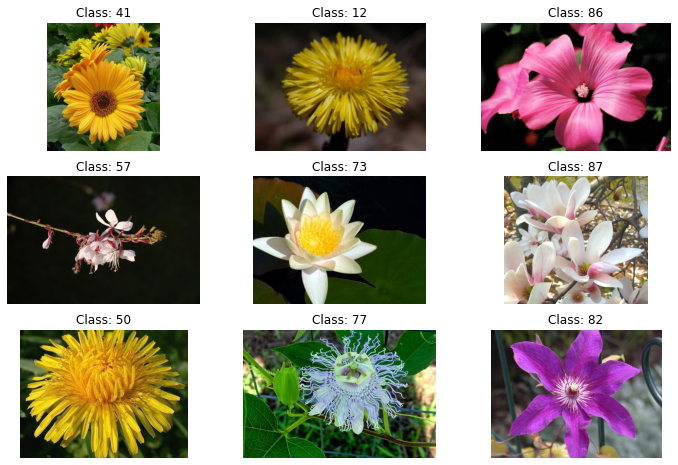

In [5]:
print('Sample pictures (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values
PATH_1=DATA_PATH
for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH_1+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

# Visualizing Random sample of images for class 4

Sample pictures (random sample)


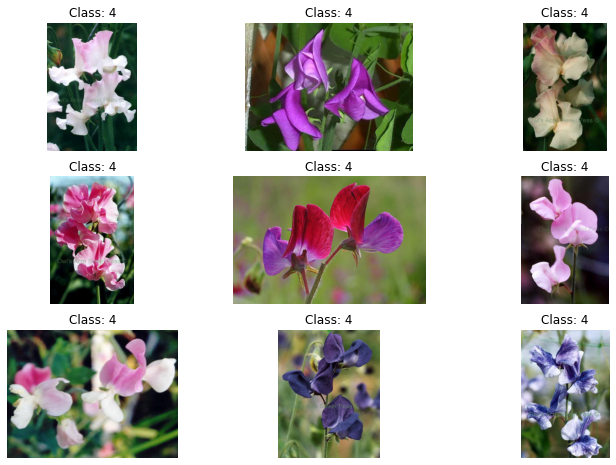

In [6]:
# make sure the class labels are loaded correctly
print('Sample pictures (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='4'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH_1+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

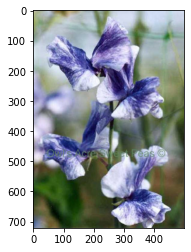

(500, 721)

In [7]:
# as you can see the images have different sizes
image = PIL.Image.open(PATH_1+path)
imgplot = plt.imshow(image)
plt.show()
image.size

# Splitting the Data randomly (by seed=51) into train/test/validation

In [8]:
# train / test
train_files, test_files, train_labels, test_labels= \
    train_test_split(df['Id'], df['Category'], test_size=0.25, random_state=51, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)

train_files['Category'] = train_labels
test_files['Category'] = test_labels


train_files.shape, test_files.shape

((6141, 2), (2048, 2))

In [9]:
train_files, val_files, train_labels, val_labels = \
    train_test_split(train_files['Id'], train_files['Category'], test_size=0.333334, random_state=51, stratify=train_files['Category'])

train_files = pd.DataFrame(train_files)
val_files = pd.DataFrame(val_files)
train_files['Category'] = train_labels
val_files['Category'] = val_labels

val_files.shape, test_files.shape, train_files.shape

((2048, 2), (2048, 2), (4093, 2))

# using ImageDataGenerator for Rescaling and Augmentations

In [10]:
# I put the main settings in the setup, so it’s more convenient to sort them out in the future
BATCH_SIZE           = 32 

CLASS_NUM            = 102
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [11]:
# Data augmentation is very important when we do not have a large dataset (as in our case)

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# "Wrapping" our data in a generator

In [12]:


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH_1,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True, 
    seed=RANDOM_SEED)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_files,
    directory=PATH_1,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True, 
    seed=RANDOM_SEED)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH_1,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False, 
    seed=RANDOM_SEED)

Found 4093 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.
Found 2048 validated image filenames belonging to 102 classes.


In [13]:
test_generator.image_shape

(224, 224, 3)

Sample pictures from train_generator


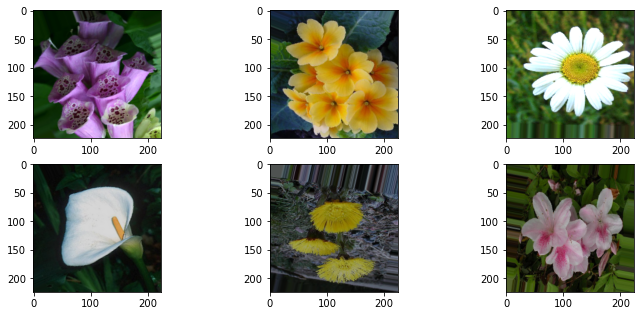

In [14]:


def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Sample pictures from train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Using the pre-trained VGG16 model and rebuilding the top layers

In [19]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


In [16]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [32]:
NUM_CLASSES=102
inputs = layers.Input(shape=input_shape)

base_model = tf.keras.applications.VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="VGG16")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)



In [33]:
len(model.trainable_variables)

4

In [34]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Fitting the model on the data and evaluating it

In [35]:
initial_epochs = 11
loss0, accuracy0 = model.evaluate(val_generator)

64/64 [==============================] - 399s 6s/step - loss: 4.7967 - accuracy: 0.0117


In [36]:
%%time 
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    callbacks=[tl_checkpoint_1, early_stop])

Epoch 1/11
128/128 [==============================] - ETA: 0s - loss: 3.8302 - accuracy: 0.1586
Epoch 1: val_loss improved from 3.96184 to 3.95172, saving model to tl_model_v1.weights.best.hdf5
128/128 [==============================] - 1229s 10s/step - loss: 3.8302 - accuracy: 0.1586 - val_loss: 3.9517 - val_accuracy: 0.1846
Epoch 2/11
128/128 [==============================] - ETA: 0s - loss: 2.5656 - accuracy: 0.3953
Epoch 2: val_loss improved from 3.95172 to 3.05223, saving model to tl_model_v1.weights.best.hdf5
128/128 [==============================] - 1452s 11s/step - loss: 2.5656 - accuracy: 0.3953 - val_loss: 3.0522 - val_accuracy: 0.4561
Epoch 3/11
128/128 [==============================] - ETA: 0s - loss: 2.0523 - accuracy: 0.5004
Epoch 3: val_loss improved from 3.05223 to 2.20742, saving model to tl_model_v1.weights.best.hdf5
128/128 [==============================] - 1416s 11s/step - loss: 2.0523 - accuracy: 0.5004 - val_loss: 2.2074 - val_accuracy: 0.5576
Epoch 4/11
128/1

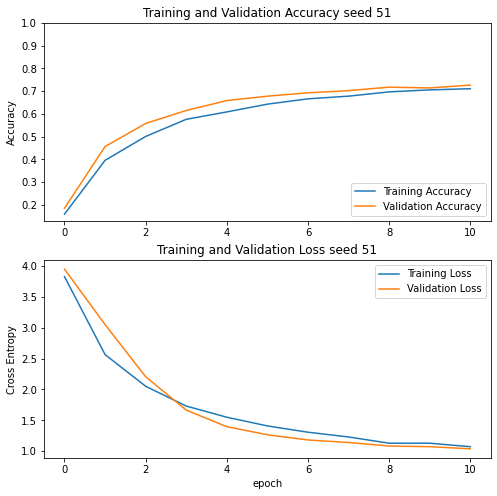

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid(False)
plt.title('Training and Validation Accuracy seed 51')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,0.1])
plt.title('Training and Validation Loss seed 51')
plt.xlabel('epoch')
plt.grid(False)
plt.show()

# Fine-Tuning VGG16 model

In [38]:
model.trainable = True

In [39]:
len(model.layers)

23

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  23


In [41]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=5.0e-5),
              metrics=['accuracy'])

In [42]:
len(model.trainable_variables)

6

In [43]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [44]:
fine_tune_epochs = 10
initial_epochs = 11
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator)

Epoch 11/21


/Users/esraan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


128/128 [==============================] - 1444s 11s/step - loss: 0.9594 - accuracy: 0.7339 - val_loss: 1.0306 - val_accuracy: 0.7285
Epoch 12/21
128/128 [==============================] - 1384s 11s/step - loss: 0.8134 - accuracy: 0.7789 - val_loss: 0.8855 - val_accuracy: 0.7642
Epoch 13/21
128/128 [==============================] - 1359s 11s/step - loss: 0.7152 - accuracy: 0.8055 - val_loss: 0.8377 - val_accuracy: 0.7773
Epoch 14/21
128/128 [==============================] - 1409s 11s/step - loss: 0.6978 - accuracy: 0.8087 - val_loss: 0.7794 - val_accuracy: 0.7930
Epoch 15/21
128/128 [==============================] - 1554s 12s/step - loss: 0.6237 - accuracy: 0.8273 - val_loss: 0.7911 - val_accuracy: 0.7842
Epoch 16/21
128/128 [==============================] - 1385s 11s/step - loss: 0.5992 - accuracy: 0.8273 - val_loss: 0.7574 - val_accuracy: 0.7910
Epoch 17/21
128/128 [==============================] - 1335s 10s/step - loss: 0.5638 - accuracy: 0.8412 - val_loss: 0.7189 - val_accurac

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

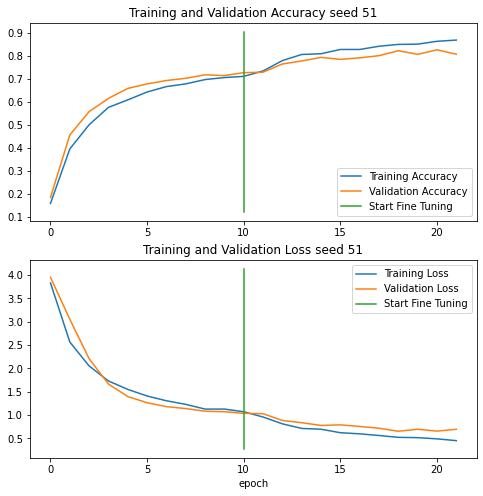

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy seed 51')
plt.grid(False)
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss seed 51')
plt.gcf().savefig('Training and Validation Loss and accuracy after tunning seed 51')
plt.grid(False)
plt.xlabel('epoch')
plt.show()

# hyper-parameter tuning of VGG16

In [47]:
epochs = 30

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

In [48]:
#fit the model
history = model.fit(train_generator, 
                    epochs=epochs,
                    validation_data = val_generator,
                    callbacks=[early_stopper, reduce_lr])

Epoch 1/30
128/128 [==============================] - 1340s 10s/step - loss: 0.4560 - accuracy: 0.8722 - val_loss: 0.6152 - val_accuracy: 0.8350 - lr: 5.0000e-05
Epoch 2/30
128/128 [==============================] - 1352s 11s/step - loss: 0.4186 - accuracy: 0.8847 - val_loss: 0.6496 - val_accuracy: 0.8232 - lr: 5.0000e-05
Epoch 3/30
128/128 [==============================] - 1422s 11s/step - loss: 0.3958 - accuracy: 0.8876 - val_loss: 0.6183 - val_accuracy: 0.8369 - lr: 5.0000e-05
Epoch 4/30
128/128 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8925
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
128/128 [==============================] - 1612s 13s/step - loss: 0.3775 - accuracy: 0.8925 - val_loss: 0.6086 - val_accuracy: 0.8398 - lr: 5.0000e-05
Epoch 5/30
128/128 [==============================] - 1409s 11s/step - loss: 0.3666 - accuracy: 0.9008 - val_loss: 0.5705 - val_accuracy: 0.8462 - lr: 1.2500e-05
Epoch 6/30
128/128 [=========

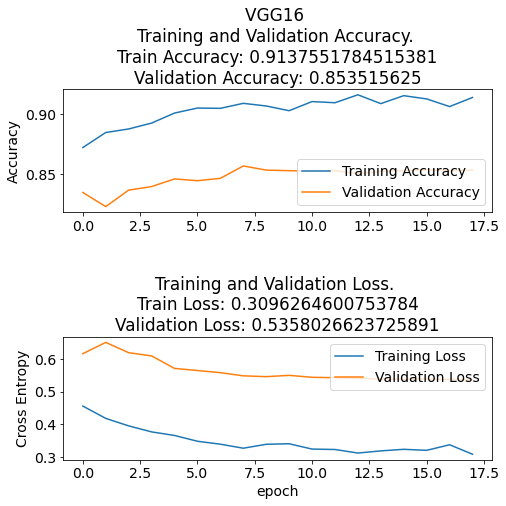

In [49]:

#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'VGG16 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.grid(False)
#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.gcf().savefig('Training and Validation Loss and accuracy final seed 51')
plt.grid(False)
plt.show()

In [50]:
scores = model.evaluate(test_generator)

64/64 [==============================] - 445s 7s/step - loss: 0.5379 - accuracy: 0.8545


In [51]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     